
### 20251210
----------------------------------------

跑一下：
w32b32 
w32b64
w32b128
w32b256
```bash
nohup python pred_snap.py --model mistral-7B-instruct-v0.2 --compress_args_path ablation_c4096_w32_b32_k7_maxpool.json > 20251210c4096w32b32.log 2>&1 &
nohup python pred_snap.py --model mistral-7B-instruct-v0.2 --compress_args_path ablation_c4096_w32_b64_k7_maxpool.json > 20251210c4096w32b64.log 2>&1 &
nohup python pred_snap.py --model mistral-7B-instruct-v0.2 --compress_args_path ablation_c4096_w32_b128_k7_maxpool.json > 20251210c4096w32b128.log 2>&1 &
nohup python pred_snap.py --model mistral-7B-instruct-v0.2 --compress_args_path ablation_c4096_w32_b256_k7_maxpool.json > 20251210c4096w32b256.log 2>&1 &
```

w64b32
w64b128
w64b512
w64c2048b64
```bash
nohup python pred_snap.py --model mistral-7B-instruct-v0.2 --compress_args_path ablation_c4096_w64_b32_k7_maxpool.json > 20251210c4096w64b32.log 2>&1 &
nohup python pred_snap.py --model mistral-7B-instruct-v0.2 --compress_args_path ablation_c4096_w64_b128_k7_maxpool.json > 20251210c4096w64b128.log 2>&1 &
nohup python pred_snap.py --model mistral-7B-instruct-v0.2 --compress_args_path ablation_c4096_w64_b512_k7_maxpool.json > 20251210c4096w64b512.log 2>&1 &
nohup python pred_snap.py --model mistral-7B-instruct-v0.2 --compress_args_path ablation_c2048_w64_b64_k7_maxpool.json > 20251210c2048w64b64.log 2>&1 &
```


w64b64 141/200=70.5%
w64   196/400=49%

**照理说c4096b4096和原先只生成一个补偿token的方案是等效的，但是原方案要不也实验一下做个对照？**
```bash
nohup python pred_snap.py --model mistral-7B-instruct-v0.2 --compress_args_path ablation_c4096_w64_fullc_k7_maxpool.json > 20251210c4096w64fullc.log 2>&1 &
```

| 窗口大小 | 最大缓存容量 | 补偿块大小 | 显存消耗  | 推理速度(s) | 正确率                |
|------|--------|-------|-------|---------|--------------------|
| 16   | 4096   | 无补偿   | 20430 | 331     | 66/400 = 16.5% *   |
| 32   | 4096   | 无补偿   | 20430 | 336     | 110/494 = 22.3% *  |
| 32   | 2048   | 无补偿   | 18485 | 311     | 278/600 = 46.3%    |
| 64   | 4096   | 无补偿   | 20430 | 331     | 131/200 =65.5% *   |
| 32   | 4096   | 32    | 20430 | -       | 109/200 = 54.5%    |
| 32   | 4096   | 64    | 20430 | -       | 120/200 = 60%      |
| 32   | 4096   | 128   | 20430 | -       | 124/200 = 62%      |
| 32   | 4096   | 256   | 20430 | -       | -                  |
| 64   | 2048   | 32    | -     | -       | -                  |
| 64   | 4096   | 32    | 20430 | -       | 112/200 = 56.0%    |
| 64   | 4096   | fullc | 20430 | 334     | 112/200 = 56.0%    |
| 64   | 4096   | 64    | 20430 | 356     | 127/200=63.5%      |
| 64   | 4096   | 128   | 20430 | -       | 118 / 200 = 59.0%  |
| 64   | 4096   | 256   | 20430 | 341     | 121/200 = 60.5%    |
| 64   | 4096   | 512   | 20430 | -       | 106/199 = 53.27% * |
| 64   | 4096   | 1024  | 20430 | 336     | 127/200 = 63.5%    |
| 64   | 4096   | 4096  | 20430 | 335     | 126/200 = 63%      |
| 64   | 1024   | 64    | -     | 312     | 118/200 = 59%      |


加了补偿块之后显存消耗几乎不变，计算时间稍微变长（7.5%）


- 窗口大小（在现在的尺度下）和缓存容量对精准度的影响都是单调的：窗口↑、缓存容量↑ = 精准度↑
- 缓存块的大小对精准度的影响感觉是有个极值的，太大太小精准度都会变低，极值位置也受窗口大小影响： 看了w64的结果之后补做了w64更多细分、w32以及原先补偿方案
  - 缓存块的大小可以尝试找到最优点，正好可以补充实验丰富度 → 可以提前预计算；如果要做实时的自适应，那就需要一个实时评估当前模型面对当前上下文性能的方案，这个不知道咋整 
  - 缓存块大小调好了是比原补偿方案好的
  - 但：加了补偿后的精准度目前都低于无补偿，但最小差距只有2% → 可能是GPT判断正误的误差

但是正确率GPT评估太不稳定了，每次实验结果拿给他判断好几次每次都有浮动
- 更新：统一了一下，从回答里截取前200条然后统一prompt，判断结果基本就稳定了
- 查一下其他论文的评估指标是怎么得到的（有统一评估脚本？换能直接量化acc的数据集？）



### 20251216
- 先解决正确率问题：看其他文章正确率是怎么评估的（可以看代码有没有评估部分）
  - 参考其他KV缓存工作里的指标，确定要评估的指标和对比方案

论文中的评估指标：

### 模型性能指标：
Needle-in-a-Haystack: 
- 长上下文寻回挑战（阅读理解），用于测试模型处理长上下文的能力，正好用于KV缓存压缩场景下记忆丢失的问题
- 基本所有KV缓存压缩文章都用了这个（razorattention（甚至只用了这个就足够展示性能）、snapkv、pyramidkv这些都用了）
- 评估也是需要模型进行评估，但是有个开源仓库，里面有写好的评估代码，还提供了可视化，这个可视化在很多KV缓存论文里都看到过，所以标准是统一的

![img.png](img.png)

LongBench：
- 长上下文阅读理解数据集，内部还有多个任务类型（QA、总结...），适合评估模型处理长上下文的能力
- 这个也是基本所有的文章都用的
- 查了一下，longbench也有一个自己的仓库，然后仓库里面提供了个评估脚本（不是模型，是综合了F1分数、正则之类的指标然后定了一个性能分数的计算方式）
- 用他的脚本算出来的性能分数是统一的，应该以这个分数为准，分数差不多长这样：

![img_1.png](img_1.png)

--------------------------

前面两个是最常见的（应该是KV缓存领域认可度很高的），不少论文甚至只需要用其中一个就足够证明
后面还有一些论文用了比较通用的评估LLM性能的数据集，但是有这些问题：
- 这种数据集比较多比较杂，要找到用了同一数据集的可能很少：对比基线少
- 用的论文一般都比较老（H2O这种）可能认可度没有前面两个高，能用前面两个数据集就用

OpenBookQA、PiQA、COPA这些，也是开源数据集
一般要这几个一起展示，应该是为了平行对比不同任务性能，只需要展示一个得分，应该也是数据集内部给了评估脚本或者直接用的正确率
- 比较新的文章（比如snapkv）不一定用了，然后不同的文章喜欢从里面挑几个，横向对比很麻烦
- 要跑好几个数据集，kv缓存相关的代码不太好直接--model把模型传进去就跑，要把数据集测试代码写到这边的采样代码里，所以每个数据集要单独写，太麻烦收益又太低，不用这些


### 解码速度和显存消耗量指标
这个就比较直观，一般展示下面的数据：
解码速度：Decoding latency
显存消耗：取最大值就行


对比方案：
- 一定有的是自己和fullkv的对比，主要对比上面数据集的得分证明方案性能（有些文章就只有这个也够，像CaM）
  - 然后一般要做自己方案里不同超参数和不同功能开关的消融实验，就可以一个方案多列几行（snapkv在内的几乎所有文章都这么干）
- 然后一般还会对比一个其他方案（感觉就是这个文章方案的主要参考方案，比如snapkv对比的就是H2O，RKV对比的就是snapkv）
  - 这个我们直接对比snapkv即可


- 低缓存容量补偿效果可能较好，可以考虑看探索或者作为主要贡献：尝试找到边界
  - 探索补偿后不降低正确率的界限：缓存块大小 - 正确率降不降低
  - 探索补偿后效果更好的缓存容量
- 补偿后正确率反而降低的原因需要找到 


```bash
cd D:\Git\SnapKV\experiments\LongBench
python eval_auto.py --model all
```

无补偿性能（对照组）

| 窗口大小 | 最大缓存容量 | 补偿块大小 | 显存消耗  | 推理速度(s) | LongBench得分 |
|------|--------|-------|-------|---------|------------|
| 16   | 4096   | 无补偿   | 20430 | 331     | 33.56      |
| 32   | 512    | 无补偿    | -     | 312     | 28.78      |
| 32   | 1024   | 无补偿    | -     | 312     | 29.57      |
| 32   | 2048   | 无补偿   | 18485 | 311     | 32.44      |
| 32   | 4096   | 无补偿   | 20430 | 336     | 33.71      |
| 64   | 4096   | 无补偿   | 20430 | 331     | 33.05      |

滑动窗口性能：

| 窗口大小 | 最大缓存容量 | LongBench得分 |
|------|--------|------------|
| 32   | 512    | 15.15      |
| 32   | 1024   |  17.63      |
| 32   | 2048   |  22.21      |
| 32   | 4096   |  29.49      |

这个其实应该对比的是StreammingLLM这个方法，这个方法比较老还没部署
但是参考来自PyramidKV这篇文章(arxiv2024 137被引)的数据，这个滑动窗口性能和SLM是相当的（分数差2分，因为sink设置比他小，但是分数趋势和总体大小在缓存相同的时候是很相似的）

滑动窗口 + 补偿：

| 窗口大小 | 最大缓存容量 | LongBench得分 |
|------|--------|-------------|
| 32   | 512    | 15.31           |
| 32   | 1024   | 17.3           |
| 32   | 2048   | 22.11           |
| 32   | 4096   | 29.24           |

- 加权注意力，权重为观察窗口的注意力
- 提升很小，基本是有轻微损失（损失幅度和topk+块补偿方案里单块的基本相当），为什么？不过这么说是不是因为目前补偿原理有问题？如果解决了补偿原理的问题，很可能块补偿也能提升？
    - 很可能是因为razorattention里面要改模型注意力实现，也就是模型源码中的注意力计算需要修改，但这篇不开源，另外两篇补偿的也和当前方案差别太大
    - 1：要么再调研一下滑动窗口+token合并的补偿方案，然后把代码挪过来测试
    - 2：要么尝试针对razorattention论文中的公式修改模型注意力源代码（这个因为没有开源保证，实现难度也比较高（以后每个模型都得改），最后再试）
    - 3：要么试一下移植cam补偿方案（这个也要改模型源码，但好歹是开源的，可以试一下）
- 现在暂定试一下方案3

论文数据：
和我的实验数据误差低于0.2

| 窗口大小 | 最大缓存容量 | 补偿块大小 | 显存消耗  | 推理速度(s) | LongBench得分 |
|------|--------|-------|-------|---------|------------|
| 16   | 1024   | 无补偿   | - | -     | 27.14      |
| 32   | 1024    | 无补偿    | -     | -     | 29.51      |
| 32k5 | 1024    | 无补偿    | -     | -     | 26.79      |
| 64   | 1024   | 无补偿    | -     | -     | 27.28      |
| 16k5 | 1024   | 无补偿    | -     | -     | 29.51      |
| 16k5 | 2048   | 无补偿    | -     | -     | 32.47      |
| 16k5 | 4096   | 无补偿    | -     | -     | 33.36      |





| 窗口大小 | 最大缓存容量 | 补偿块大小 | 显存消耗  | 推理速度(s) | LongBench得分 |
|------|--------|-------|-------|---------|------------|
| 16   | 4096   | 64    | 20430 | -       | 32.47      |
| 32   | 4096   | 32    | 20430 | -       | 32.53      |
| 32   | 4096   | 64    | 20430 | -       | 32.11      |
| 32   | 4096   | 128   | 20430 | -       | 32.48      |
| 32   | 4096   | 256   | 20430 | -       | 33.11      |

| 窗口大小 | 最大缓存容量 | 补偿块大小 | 显存消耗  | 推理速度(s) | LongBench得分 |
|------|--------|-------|-------|---------|------------|
| 64   | 2048   | 64    | -     | -       | 31.71      |
| 64   | 4096   | fullc | 20430 | 334     | 32.96      |
| 64   | 4096   | 32    | 20430 | -       | 32.32      |
| 64   | 4096   | 64    | 20430 | 356     | 31.72      |
| 64   | 4096   | 128   | 20430 | -       | 32.58      |
| 64   | 4096   | 256   | 20430 | 341     | 32.71      |
| 64   | 4096   | 512   | 20430 | -       | 32.99      |
| 64   | 4096   | 1024  | 20430 | 336     | 32.94      |
| 64   | 4096   | 4096  | 20430 | 335     | 32.95      |
| 64   | 1024   | 64    | -     | 312     | 29.97      |

| 窗口大小 | 最大缓存容量 | 补偿块大小 | LongBench得分 |
|------|--------|-------|-------------|
| 32   | 1024   | 无补偿   | 29.57       |
| 32   | 1024   | 16    | 27.17       |
| 32   | 1024   | 32    | 28.39       |
| 32   | 1024   | 64    | 29.08       |
| 32   | 1024   | 128   | 28.9        |
| 32   | 1024   | 256   | 29.6        |
| 32   | 1024   | 512   | 29.42       |
| 32   | 1024   | 1024  | 29.42       |

| 窗口大小 | 最大缓存容量 | 补偿块大小 | LongBench得分 |
|------|--------|-------|-------------|
| 32   | 2048   | 无补偿   | 32.44           |
| 32   | 2048   | 16    | 29.78           |
| 32   | 2048   | 32    | 31.08           |
| 32   | 2048   | 64    | 31.26           |
| 32   | 2048   | 128   | 32.19           |
| 32   | 2048   | 256   | 32.19           |
| 32   | 2048   | 512   | 32.23          |
| 32   | 2048   | 1024  | 32.45          |

| 窗口大小 | 最大缓存容量 | 补偿块大小 | LongBench得分 |
|------|--------|-------|-------------|
| 64   | 4096   | 无补偿   | 33.05           |
| 64   | 4096   | 32    | 32.32           |
| 64   | 4096   | 64    | 31.72           |
| 64   | 4096   | 128   | 32.58           |
| 64   | 4096   | 256   | 32.71           |
| 64   | 4096   | 512   | 32.99           |
| 64   | 4096   | 1024  | 32.94           |
| 64   | 4096   | 4096  | 32.95           |


补充：低缓存容量的补偿块大小-得分实验
```bash
nohup python pred_snap.py --model mistral-7B-instruct-v0.2 --compress_args_path ablation_c1024_w32_b16_k7_maxpool.json > 20251221c1024w32b16.log 2>&1 &
nohup python pred_snap.py --model mistral-7B-instruct-v0.2 --compress_args_path ablation_c1024_w32_b32_k7_maxpool.json > 20251221c1024w32b32.log 2>&1 &
nohup python pred_snap.py --model mistral-7B-instruct-v0.2 --compress_args_path ablation_c1024_w32_b64_k7_maxpool.json > 20251221c1024w32b64.log 2>&1 &
nohup python pred_snap.py --model mistral-7B-instruct-v0.2 --compress_args_path ablation_c1024_w32_b128_k7_maxpool.json > 20251221c1024w32b128.log 2>&1 &
nohup python pred_snap.py --model mistral-7B-instruct-v0.2 --compress_args_path ablation_c1024_w32_b256_k7_maxpool.json > 20251221c1024w32b256.log 2>&1 &
nohup python pred_snap.py --model mistral-7B-instruct-v0.2 --compress_args_path ablation_c1024_w32_b512_k7_maxpool.json > 20251221c1024w32b512.log 2>&1 &
nohup python pred_snap.py --model mistral-7B-instruct-v0.2 --compress_args_path ablation_c1024_w32_b1024_k7_maxpool.json > 20251221c1024w32b1024.log 2>&1 &

chmod +x autorun.sh
nohup ./autorun.sh > autorun.nohup.log 2>&1 &

pkill -f run_seq.sh

```


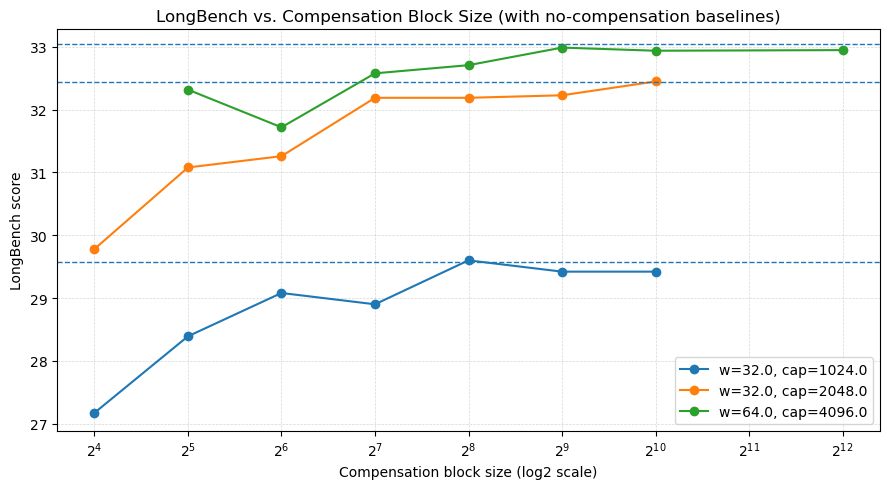

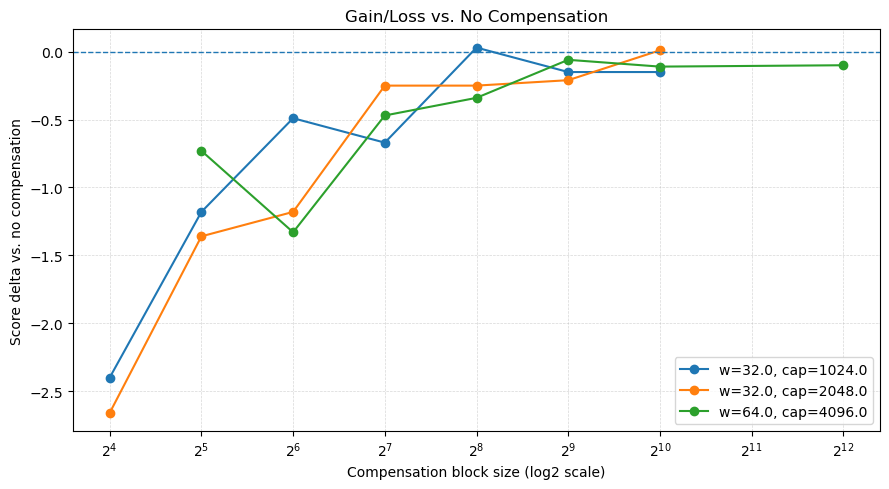

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


data = [
    # w=32, cap=1024
    {"window": 32, "capacity": 1024, "block": None, "score": 29.57},  # 无补偿
    {"window": 32, "capacity": 1024, "block": 16,   "score": 27.17},
    {"window": 32, "capacity": 1024, "block": 32,   "score": 28.39},
    {"window": 32, "capacity": 1024, "block": 64,   "score": 29.08},
    {"window": 32, "capacity": 1024, "block": 128,  "score": 28.90},
    {"window": 32, "capacity": 1024, "block": 256,  "score": 29.60},
    {"window": 32, "capacity": 1024, "block": 512,  "score": 29.42},
    {"window": 32, "capacity": 1024, "block": 1024, "score": 29.42},

    # w=32, cap=2048
    {"window": 32, "capacity": 2048, "block": None, "score": 32.44},  # 无补偿
    {"window": 32, "capacity": 2048, "block": 16,   "score": 29.78},
    {"window": 32, "capacity": 2048, "block": 32,   "score": 31.08},
    {"window": 32, "capacity": 2048, "block": 64,   "score": 31.26},
    {"window": 32, "capacity": 2048, "block": 128,  "score": 32.19},
    {"window": 32, "capacity": 2048, "block": 256,  "score": 32.19},
    {"window": 32, "capacity": 2048, "block": 512,  "score": 32.23},
    {"window": 32, "capacity": 2048, "block": 1024, "score": 32.45},

    # w=64, cap=4096
    {"window": 64, "capacity": 4096, "block": None, "score": 33.05},  # 无补偿
    {"window": 64, "capacity": 4096, "block": 32,   "score": 32.32},
    {"window": 64, "capacity": 4096, "block": 64,   "score": 31.72},
    {"window": 64, "capacity": 4096, "block": 128,  "score": 32.58},
    {"window": 64, "capacity": 4096, "block": 256,  "score": 32.71},
    {"window": 64, "capacity": 4096, "block": 512,  "score": 32.99},
    {"window": 64, "capacity": 4096, "block": 1024, "score": 32.94},
    {"window": 64, "capacity": 4096, "block": 4096, "score": 32.95},
]

df = pd.DataFrame(data)
df["group"] = df.apply(lambda r: f"w={r['window']}, cap={r['capacity']}", axis=1)

# 取各组“无补偿”基线
baseline = (
    df[df["block"].isna()]
    .set_index("group")["score"]
    .to_dict()
)

# 只保留有补偿的点（block 非空）
df_comp = df[df["block"].notna()].copy()
df_comp["delta_vs_no_comp"] = df_comp.apply(lambda r: r["score"] - baseline[r["group"]], axis=1)

# =======================
# 2) 图1：绝对得分曲线 + 基线
# =======================
plt.figure(figsize=(9, 5))
for g, sub in df_comp.groupby("group"):
    sub = sub.sort_values("block")
    plt.plot(sub["block"], sub["score"], marker="o", label=g)
    # 画无补偿基线（水平虚线）
    plt.axhline(baseline[g], linestyle="--", linewidth=1)

plt.xscale("log", base=2)
plt.xlabel("Compensation block size (log2 scale)")
plt.ylabel("LongBench score")
plt.title("LongBench vs. Compensation Block Size (with no-compensation baselines)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# =======================
# 3) 图2：相对无补偿的增益/损失
# =======================
plt.figure(figsize=(9, 5))
for g, sub in df_comp.groupby("group"):
    sub = sub.sort_values("block")
    plt.plot(sub["block"], sub["delta_vs_no_comp"], marker="o", label=g)

plt.axhline(0.0, linestyle="--", linewidth=1)
plt.xscale("log", base=2)
plt.xlabel("Compensation block size (log2 scale)")
plt.ylabel("Score delta vs. no compensation")
plt.title("Gain/Loss vs. No Compensation")
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


规律：
- 补偿后得分大都低于无补偿方案
- 补偿块随着变大，得分总体有上升趋势
    - 补偿块大实际上就对应的补偿token更少，意思是否是补偿token的存在反而降低了模型性能？

为何低于无补偿？
- 补偿后注意力需要单独计算？
    - 在有几个方案里提到了他们的补偿token注意力要单独计算，但这会引入几个问题：
        - 如何计算补偿token注意力（数学推导）
        - 补偿token需要被标记，然后模型的monkey patch里也要修改模型源码以加入补偿token的注意力特判

- RoPE模型的位置编码？ 这个我不了解，有些补偿方案确实要考虑这个


调研：
- 补偿方案的数学原理（重点关注注意力计算、位置编码），尤其是在snapkv这种topK方案中进行补偿的

- 今天晚上刚刚想到的：这样的话有没有可能是因为即使是1024的缓存容量也相对充足？要不也在例如128、256这种极端容量下再实验一下？


| 窗口大小 | 最大缓存容量 | 补偿块大小 | LongBench得分  |
|------|--------|-------|--------------|
| 32   | 1024   | 无补偿   | 29.57        |
| 32   | 512    | 无补偿   | 28.78        |
| 32   | 256    | 无补偿   | 23.56        |
| 32   | 128    | 无补偿   | 21.0         |
| 32   | 1024   | 1024   | 29.42        |
| 32   | 512    | 1024   | 27.38        |
| 32   | 256    | 1024   | 23.42        |
| 32   | 128    | 1024   | 21.59        |

### 20251225：
- 验证滑动窗口策略下的补偿是否有效：复现一些基于滑动窗口的补偿策略

